In [1]:
import altair as alt
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

In [2]:
# Suppress warnings.
import warnings
warnings.filterwarnings("ignore")

# Suppress js errors.
alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

In [3]:
DATA_DIR = 'csv/'
IMG_DIR = 'img/'

### Data: Monsoon

In [4]:
monsoon = pd.read_csv(DATA_DIR + 'Monsoon_data.csv', parse_dates=['Date'])
monsoon.set_index('Date', drop=False, inplace=True)

In [5]:
monsoon['dataset'] = 'monsoon'
monsoon['date_str'] = monsoon['Date'].astype(str)
monsoon['year'] = monsoon['date_str'].str[:4]
monsoon['month'] = pd.to_numeric(monsoon['date_str'].str[5:7])

# This could be more elegant.
monsoon.loc[monsoon['month'] <= 12, 'quarter'] = 4
monsoon.loc[monsoon['month'] <= 9, 'quarter'] = 3
monsoon.loc[monsoon['month'] <= 6, 'quarter'] = 2
monsoon.loc[monsoon['month'] <= 3, 'quarter'] = 1

In [6]:
# monsoon.head(20)

### Data: Olou

In [7]:
olou = pd.read_csv(DATA_DIR + 'Olou_counts.csv', parse_dates=['Date'])
olou.set_index('Date', drop=False, inplace=True)

In [8]:
olou['dataset'] = 'olou'
olou['date_str'] = olou['Date'].astype(str)
olou['year'] = olou['date_str'].str[:4]
olou['month'] = pd.to_numeric(olou['date_str'].str[5:7])

# This could be more elegant.
olou.loc[olou['month'] <= 12, 'quarter'] = 4
olou.loc[olou['month'] <= 9, 'quarter'] = 3
olou.loc[olou['month'] <= 6, 'quarter'] = 2
olou.loc[olou['month'] <= 3, 'quarter'] = 1

In [9]:
# olou.head()

### Data: Monsoon + Olou

In [10]:
dataframes = [monsoon, olou]
dataset = pd.concat(dataframes)

In [11]:
# dataset.head()

#### Define a common date range

In [12]:
# Larger min date of either set is chart's min date.
if monsoon.index.min() < olou.index.min():
    min_x_date = olou.index.min()
else:
    min_x_date = monsoon.index.min()

# Smaller max date of either set is chart's max date.
if monsoon.index.max() < olou.index.max():
    max_x_date = monsoon.index.max()
else:
    max_x_date = olou.index.max()

#### Exclude dates not in both sets

In [13]:
dataset = dataset[(dataset['Date'] >= min_x_date) & (dataset['Date'] <= max_x_date)]

In [14]:
# dataset.head()

In [15]:
# Selections.
select = alt.selection_interval(
    bind="scales",
    encodings=['x', 'y']
)

# min_x is the LARGER min date of the two sets.
if olou.index.min() < monsoon.index.min():
    min_x = monsoon.index.min()
else:
    min_x = olou.index.min()

# max_x is the SMALLER max date of the two sets.
if olou.index.max() < monsoon.index.max():
    max_x = olou.index.max()
else:
    max_x = monsoon.index.max()

x_domain = [min_x, max_x]

# Domain ranges.
olou_domain = [dataset['Counts'].min(), dataset['Counts'].max()]
monsoon_domain = [dataset['Precip'].min(), dataset['Precip'].max()]

In [16]:
# Monsoon precipitation.
line_chart_monsoon = alt.Chart(dataset[np.isnan(dataset['Precip']) == False]).mark_line(
    interpolate='basis',
    strokeWidth=2.5,
    opacity=0.25
).encode(
    x=alt.X('Date:T', title="", scale=alt.Scale(domain=x_domain)),
    y=alt.Y('Precip:Q', scale=alt.Scale(domain=monsoon_domain)),
    color=alt.Color("dataset", legend=alt.Legend(symbolType='circle'))
).add_params(
    # param_width,
    select
)

# Monsoon precipitation rolling average.
moving_avg_monsoon = alt.Chart(dataset[np.isnan(dataset['Precip']) == False]).transform_window(
    rolling_mean='mean(Precip)',
    frame=[-3, 3],
).mark_line(
    color='green',
    strokeWidth=2,
    interpolate='basis'
).encode(
    x=alt.X('Date:T', scale=alt.Scale(domain=x_domain)),
    y=alt.Y('rolling_mean:Q', scale=alt.Scale(domain=monsoon_domain))
)

# Olou cosmic ray counts.
line_chart_olou = alt.Chart(dataset[np.isnan(dataset['Counts']) == False]).mark_line(
    interpolate='basis',
    strokeWidth=2.5,
    opacity=0.25
).encode(
    x=alt.X('Date:T', title="", scale=alt.Scale(domain=x_domain)),
    y=alt.Y('Counts:Q', scale=alt.Scale(domain=olou_domain)),
    color=alt.Color("dataset", legend=alt.Legend(symbolType='circle'))
).add_params(
    # param_width,
    select
)

# Olou cosmic ray counts rolling average.
moving_avg_olou = alt.Chart(dataset[np.isnan(dataset['Counts']) == False]).transform_window(
    rolling_mean='mean(Counts)',
    frame=[-15, 15],
).mark_line(
    color='red',
    strokeWidth=2,
    interpolate='basis'
).encode(
    x=alt.X('Date:T', scale=alt.Scale(domain=x_domain)),
    y=alt.Y('rolling_mean:Q', scale=alt.Scale(domain=olou_domain))
)

# Get nearest point y-value from selection.
nearest = alt.selection_point(
    nearest=True,
    on='mouseover',
    fields=['Date'],
    empty=False
)

# Monsoon selector.
selectors_monsoon = alt.Chart(dataset[dataset['dataset'] == 'monsoon']).mark_point().encode(
    x=alt.X('Date:T', scale=alt.Scale(domain=x_domain)),
    y=alt.Y('Precip:Q', scale=alt.Scale(domain=monsoon_domain)),
    opacity=alt.value(0),
).add_params(
    nearest
)

# Olou selector.
selectors_olou = alt.Chart(dataset[dataset['dataset'] == 'olou']).mark_point().encode(
    x=alt.X('Date:T', scale=alt.Scale(domain=x_domain)),
    y=alt.Y('Counts:Q', scale=alt.Scale(domain=olou_domain)),
    opacity=alt.value(0),
).add_params(
    nearest
)

# Monsoon highlighted points.
points_monsoon = alt.Chart(dataset[dataset['dataset'] == 'monsoon']).transform_filter(
    nearest
).mark_point(
    size=90, strokeWidth=1
).encode(
    x=alt.X('Date:T', scale=alt.Scale(domain=x_domain)),
    y=alt.Y('Precip:Q', scale=alt.Scale(domain=monsoon_domain)),
    color=alt.Color("dataset", legend=alt.Legend(symbolType='circle'))
)

# Olou highlighted points.
points_olou = alt.Chart(dataset[dataset['dataset'] == 'olou']).transform_filter(
    nearest
).mark_point(
    size=90, strokeWidth=1
).encode(
    x=alt.X('Date:T', scale=alt.Scale(domain=x_domain)),
    y=alt.Y('Counts:Q', scale=alt.Scale(domain=olou_domain)),
    color=alt.Color("dataset", legend=alt.Legend(symbolType='circle'))
)

# Gray draggable bar.
rules = alt.Chart(dataset).mark_rule(
    color='lightgray',
    opacity=0.4
).encode(
    x=alt.X('Date:T', scale=alt.Scale(domain=x_domain)),
    strokeWidth=alt.StrokeWidthValue(4)
).transform_filter(
    nearest
)

# Monsoon label text.
text_monsoon = alt.Chart(dataset[dataset['dataset'] == 'monsoon']).mark_text(
    align='left',
    dx=7,
    fontSize=14
).encode(
    x=alt.X('Date:T', scale=alt.Scale(domain=x_domain)),
    y=alt.X('Precip:Q', scale=alt.Scale(domain=monsoon_domain)),
    text=alt.Text('Precip', format='.2f'),
    color=alt.Color("dataset", legend=alt.Legend(symbolType='circle'))
).transform_filter(
    nearest
)

# Olou label text.
text_olou = alt.Chart(dataset[dataset['dataset'] == 'olou']).mark_text(
    align='left',
    dx=7,
    fontSize=14
).encode(
    x=alt.X('Date:T', scale=alt.Scale(domain=x_domain)),
    y=alt.Y('Counts:Q', scale=alt.Scale(domain=olou_domain)),
    text=alt.Text('Counts', format='.2f'),
    color=alt.Color("dataset", legend=alt.Legend(symbolType='circle'))
).transform_filter(
    nearest
)

### Interactive Visualization

### Stacking

In [17]:
# Olou chart.
chart_olou = alt.layer(
    line_chart_olou,
    moving_avg_olou,
    points_olou,
    selectors_olou,
    rules,
    text_olou
)

# Monsoon chart.
chart_monsoon = alt.layer(
    line_chart_monsoon,
    moving_avg_monsoon,
    points_monsoon,
    selectors_monsoon,
    rules,
    text_monsoon
)

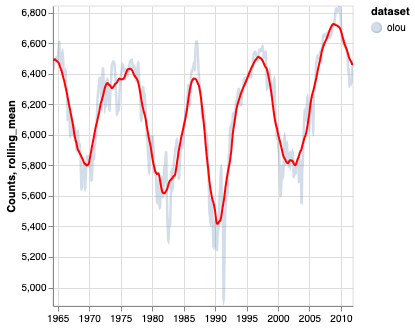

In [21]:
chart_olou

### Interactivity

In [23]:
# Init outputs.
output = widgets.Output()

# Update chart sizes.
def update_chart_width_height(width, height):
    updated_chart_olou = chart_olou.properties(width=width, height=height)
    updated_chart_monsoon = chart_monsoon.properties(width=width, height=height)
    updated_combined_chart = alt.vconcat(updated_chart_olou, updated_chart_monsoon)
    with output:
        output.clear_output(wait=True)
        display(updated_combined_chart)

# Create widgets.
width_slider = widgets.IntSlider(value=800, min=100, max=1500, step=1, description='Width:')
height_slider = widgets.IntSlider(value=155, min=10, max=300, step=1, description='Height:')

# Update charts from widgets.
def update_chart(width, height):
    update_chart_width_height(width, height)

# Activate widgets.
widgets.interactive(update_chart, width=width_slider, height=height_slider)

interactive(children=(IntSlider(value=800, description='Width:', max=1500, min=100), IntSlider(value=155, desc…

### Show Chart

In [24]:
# Chart.
display(output)

# Widgets.
display(width_slider, height_slider)

Output(outputs=({'output_type': 'display_data', 'data': {'application/vnd.vegalite.v5+json': {'config': {'view…

IntSlider(value=800, description='Width:', max=1500, min=100)

IntSlider(value=155, description='Height:', max=300, min=10)